In [220]:
from tempfile import TemporaryDirectory
from typing import Literal, Tuple, List
from random import randint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

In [225]:
# CONSTANTS AND PARAMETERS
CITIES = 50
POP_SIZE = 50
CROSS_PROB = 0.9
MUTATION_PROB = 0.8
TOURNAMENT_SIZE = 6
SELECTION_METHOD: Literal["tournament", "roulette"] = "tournament"
SUCCESSION_METHOD: Literal["full", "partial", "elitist"] = "elitist"
CITIES_X_LIMIT = 300
CITIES_Y_LIMIT = 300

In [181]:
def setup_cities(n: int, limit_x: int, limit_y: int, shape: Literal["ring", "random"] = "ring") -> Tuple[np.ndarray, np.ndarray]:
    """
    Generate random coordinates for cities.

    :param shape: Shape of the city distribution ('random' or 'ring')
    :param n: Number of cities
    :param limit_x: X-axis limit
    :param limit_y: Y-axis limit
    :return: Array of city coordinates
    """
    match shape:
        case 'random':
            x = np.random.randint(0, limit_x, size=n)
            y = np.random.randint(0, limit_y, size=n)
        case 'ring':
            angles = np.linspace(0, 2 * np.pi, n, endpoint=False)
            center_x, center_y = limit_x // 2, limit_y // 2
            radius_x, radius_y = limit_x // 2, limit_y // 2
            x = (center_x + radius_x * np.cos(angles)).astype(int)
            y = (center_y + radius_y * np.sin(angles)).astype(int)
        case _:
            raise ValueError("Shape must be either random or ring!")

    return x,y


generated_cities = setup_cities(CITIES, CITIES_X_LIMIT, CITIES_Y_LIMIT)

In [27]:
def show_cities(cities: Tuple[np.ndarray, np.ndarray]) -> None:
    """
    Visualize the cities on a scatter plot

    :param cities: Tuple of city coordinates
    """
    plt.figure(figsize=(10, 10))
    plt.scatter(cities[0], cities[1], marker='o')
    plt.xlim(-10, CITIES_X_LIMIT + 10)
    plt.ylim(-10, CITIES_Y_LIMIT + 10)
    plt.title("Cities Distribution")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.grid()
    plt.show()

In [215]:
def show_connections(cities: Tuple[np.ndarray, np.ndarray], population: np.ndarray, ind: int, tmpdir: TemporaryDirectory) -> None:
    """
    Show how the cities are connected in the best route.

    :param cities: Tuple of x and y coordinates for cities.
    :param population: The population containing chromosomes (routes) of city indices.
    :param ind: Index
    :param tmpdir: Temporary directory to save the frames.
    :return: The matplotlib figure object.
    """
    plt.figure(figsize=(10, 10))
    plt.scatter(cities[0], cities[1], marker='o')
    plt.xlim(-10, CITIES_X_LIMIT + 10)
    plt.ylim(-10, CITIES_Y_LIMIT + 10)
    plt.title("Cities Distribution")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.grid()

    best_route = population[-1]

    # Ensure that best_route contains only valid indices
    best_route = np.clip(best_route, 0, len(cities[0]) - 1)  # Ensures indices are within bounds

    # Draw lines between cities in the best route
    for i in range(len(best_route) - 1):
        # Ensure indices are integers when accessing the cities array
        index1 = int(best_route[i])  # City index from the route
        index2 = int(best_route[i + 1])  # City index from the route

        # Plot line between cities
        x_values = [cities[0][index1], cities[0][index2]]
        y_values = [cities[1][index1], cities[1][index2]]
        plt.plot(x_values, y_values, color='blue')

    plt.savefig(f"{tmpdir}/frame_{ind}.png")
    plt.close()

In [221]:
def generate_gif(cities: Tuple[np.ndarray, np.ndarray], populations: List[np.ndarray]) -> None:
    with TemporaryDirectory() as tmpdir:
        for ind, pop in enumerate(populations):
            show_connections(cities, pop, ind, tmpdir)

        frames = [Image.open(f"{tmpdir}/frame_{i}.png") for i in range(len(populations))]
        frames[0].save("cities.gif", save_all=True, append_images=frames[1:], duration=500, loop=0)


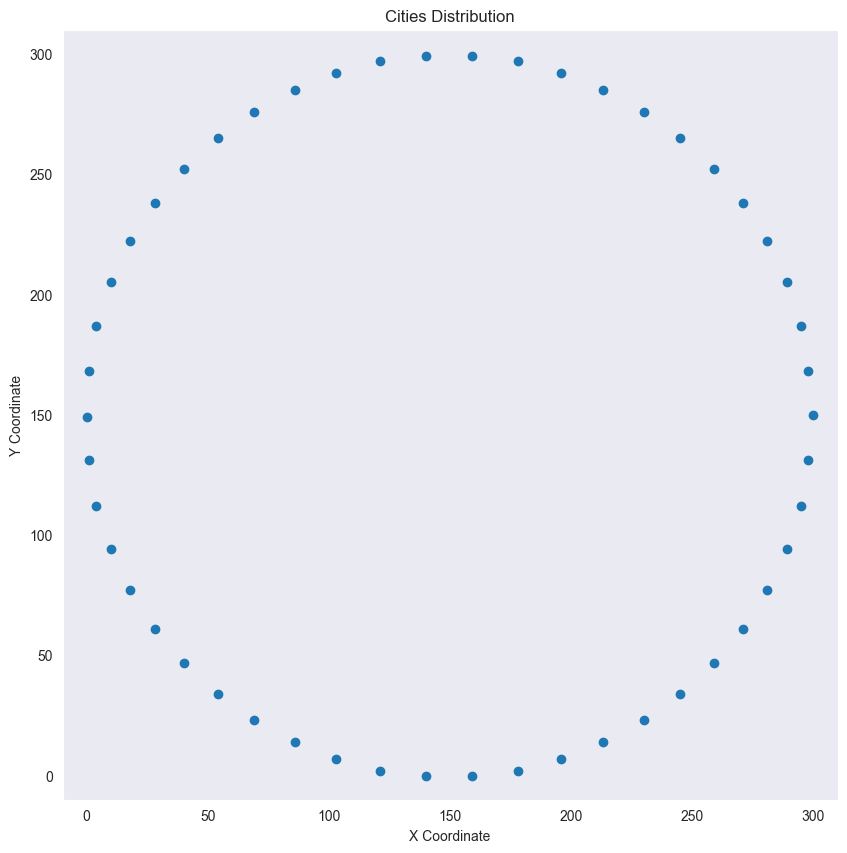

In [28]:
show_cities(generated_cities)

In [29]:
def compute_distance_matrix(cities: Tuple[np.ndarray, np.ndarray]) -> np.ndarray:
    """
    Compute the Euclidean distance matrix between all pairs of cities to be used later in the calculations

    :param cities: Tuple of city coordinates
    :return: 2D array (matrix) of distances
    """
    x, y = cities
    coords = np.stack((x, y), axis=1)
    diff = coords[:, np.newaxis, :] - coords[np.newaxis, :, :]
    dist_matrix = np.sqrt(np.sum(diff**2, axis=-1))
    return dist_matrix


distances = compute_distance_matrix(generated_cities)

In [37]:
def calculate_distance(chromosome: np.ndarray, dist_matrix: np.ndarray = distances) -> float:
    """
    Calculate the total distance of a given chromosome (route) based on the distance matrix

    :param chromosome: Chromosome representing the route
    :param dist_matrix: Distance matrix between cities
    :return: Total distance of the route
    """
    distance = sum(
        dist_matrix[chromosome[i], chromosome[i - 1]] for i in range(len(chromosome))
    )

    return distance


test_chromosome = np.random.permutation(len(generated_cities))
calculate_distance(test_chromosome, distances)

np.float64(36.22154055254967)

In [74]:
def sort_by_distance(chromosome: np.ndarray, distance_col_index: int = -1) -> np.ndarray:
    """
    Sort the population based on their distance

    :param chromosome: 2D numpy array where each row is a chromosome with distance stored in a specific column
    :param distance_col_index: Index of the column containing the distance, because the distance is the last column
    """
    return chromosome[chromosome[:, distance_col_index].argsort()]

In [73]:
def generate_initial_population(pop_size: int, num_cities: int) -> np.ndarray:
    """
    Create the initial population of candidate routes

    :param pop_size: Size of the population
    :param num_cities: Total number of cities excluding the start/end city
    :return: Initial population
    """
    population = np.empty((pop_size, num_cities + 1), dtype=int)

    for i in range(pop_size):
        path = np.random.permutation(np.arange(1, num_cities))
        # Start and end at city 0
        route = np.concatenate(([0], path, [0]))

        population[i, :] = route

    # Add distance to the last column
    distances = np.array([calculate_distance(route) for route in population])
    population = np.column_stack((population, distances))

    return sort_by_distance(population, num_cities + 1)


generate_population = generate_initial_population(POP_SIZE, CITIES)
generate_population

(500, 52)

In [172]:
def select_specimens(original_generation: np.ndarray,
                     parent_count: int,
                     selection_type: Literal["roulette", "tournament"] = "tournament",
                     tournament_size: int = TOURNAMENT_SIZE,
                     with_replacement: bool = True) -> np.ndarray:
    """
    Selects specimens from a generation based on a given selection strategy.

    :param original_generation: np.ndarray of specimens (last column is the fitness of each specimen).
    :param parent_count: Number of parents to select.
    :param selection_type: Selection strategy ('tournament', 'roulette', or 'random').
    :param tournament_size: Size of tournament (only used for tournament selection).
    :param with_replacement: Whether to allow the same specimen to be selected multiple times (only for tournament selection).
    :return: np.ndarray of selected parents sorted by fitness.
    """
    generation = original_generation.copy()

    match selection_type:
        case "tournament":
            selected_parents = []
            available_indexes = np.arange(generation.shape[0])

            # Ensure we select exactly parent_count specimens
            while len(selected_parents) < parent_count:
                tournament_indexes = np.random.choice(available_indexes, size=tournament_size, replace=False)
                tournament_specimens = generation[tournament_indexes]
                tournament_winner = tournament_specimens[np.argmin(tournament_specimens[:, -1])]
                selected_parents.append(tournament_winner)

                if not with_replacement:
                    winner_index = np.where(generation == tournament_winner)[0][0]
                    available_indexes = np.delete(available_indexes, np.where(available_indexes == winner_index)[0])

            # Remove duplicates (in case of multiple selections in case of replacement)
            selected = np.unique(np.vstack(selected_parents), axis=0)

        case "roulette":
            distances = generation[:, -1]
            # Small epsilon to avoid division by zero
            probabilities = 1 / (distances + 1e-6)
            probabilities /= np.sum(probabilities)

            selected_indices = []

            # Ensure exactly parent_count selections
            while len(selected_indices) < parent_count:
                selected_index = np.random.choice(np.arange(generation.shape[0]), p=probabilities)
                # Ensure no duplicates
                while selected_indices.count(selected_index) >= 1:
                    selected_index = np.random.choice(np.arange(generation.shape[0]), p=probabilities)
                selected_indices.append(selected_index)

            # Extract selected chromosomes from the indices
            selected = generation[selected_indices]

            selected = np.unique(selected, axis=0)

        case _:
            raise ValueError("Invalid selection type. Choose either tournament or roulette!")

    # Ensure that we return exactly parent_count specimens after sorting by fitness
    return sort_by_distance(selected)[:parent_count]


In [173]:
def mutation(chromosome: np.ndarray,
             mutation_probability: float = MUTATION_PROB,
             num_cities: int = CITIES,
             mutation_method: Literal["full", "partial"] = "full") -> np.ndarray:
    """
    Mutate a chromosome by swapping two cities with a given probability.

    :param num_cities:
    :param mutation_method: full mutation means ver1 and ver2 of mutation, while partial mutation means only ver1
    :param chromosome: Chromosome to mutate
    :param mutation_probability: Probability of mutation
    :return: Mutated chromosome
    """
    # If selected random value if larger skip mutation
    if np.random.rand() < mutation_probability:
        specimen = chromosome.copy()

        # Swap two random cities (except the starting/ending city), we don't take the last column into account
        first_ind, second_ind = np.random.choice(np.arange(1, num_cities - 1), size=2, replace=False)
        first_gene = specimen[first_ind]
        second_gene = specimen[second_ind]
        specimen[second_ind] = first_gene
        specimen[first_ind] = second_gene

        if mutation_method == "full":
            first_ind, second_ind = np.random.choice(np.arange(1, num_cities - 1), size=2, replace=False)
            tmp_spec = specimen[first_ind].copy()
            if first_ind > second_ind:
                specimen[second_ind + 1: first_ind + 1] = specimen[second_ind: first_ind]
            else:
                specimen[first_ind: second_ind] = specimen[first_ind + 1: second_ind + 1]
            specimen[second_ind] = tmp_spec

        return specimen

    return chromosome

In [174]:
def crossover(
    parent1: np.ndarray,
    parent2: np.ndarray,
    crossover_probability: float = CROSS_PROB,
    crossover_method: Literal["order", "simple"] = "order",
    num_cities: int = CITIES,
) -> np.ndarray:
    """
    Perform crossover between two parents to create a child.

    :param parent1: First parent chromosome
    :param parent2: Second parent chromosome
    :param crossover_probability: Probability of crossover
    :param crossover_method: Crossover method
    :param num_cities:
    :return: Child chromosome
    """
    if np.random.rand() < crossover_probability:
        # Randomly select two crossover points
        start, end = sorted(np.random.choice(np.arange(1, num_cities - 1), size=2, replace=False))
        child = np.full_like(parent1, -1)

        match crossover_method:
            case "order":
                # Slice from parent1
                child[start:end + 1] = parent1[start:end + 1]
                fill_index = (end + 1) % num_cities
                for gene in parent2:
                    if gene not in child:
                        child[fill_index] = gene
                        fill_index = (fill_index + 1) % num_cities

            case "simple":
                # Slice from parent2 and shuffle it
                slice_to_shuffle = parent2[start:end + 1].copy()
                np.random.shuffle(slice_to_shuffle)

                # Fill child
                child[start:end + 1] = slice_to_shuffle

                # Fill rest from parent1
                for i in range(num_cities):
                    if i < start or i > end:
                        child[i] = parent1[i]

            case _:
                raise ValueError("Invalid crossover method. Choose either order or simple!")

    return parent1.copy()

In [175]:
def generate_children(
    parents: np.ndarray,
    child_count: int = POP_SIZE,
    crossover_probability: float = CROSS_PROB,
    mutation_probability: float = MUTATION_PROB,
    crossover_method: Literal["order", "simple"] = "order",
) -> np.ndarray:
    """
    Generate children from parents using crossover and mutation.

    :param parents: Parent chromosomes
    :param child_count: Number of children to generate
    :param crossover_probability: Probability of crossover
    :param mutation_probability: Probability of mutation
    :param crossover_method: Crossover method
    :return: Generated children
    """
    children = []

    while len(children) < child_count:
        ind1, ind2 = np.random.choice(np.arange(parents.shape[0]), size=2, replace=False)
        parent1, parent2 = parents[ind1], parents[ind2]

        child = crossover(parent1, parent2, crossover_probability=crossover_probability, crossover_method=crossover_method)
        child = mutation(child, mutation_probability=mutation_probability)

        children.append(child)

    return sort_by_distance(np.array(children))

In [176]:
def succession(
        parent_generation: np.ndarray,
        children_generation: np.ndarray,
        population_size: int = POP_SIZE,
        successsion_method: Literal["full", "partial", "elitist"] = SUCCESSION_METHOD,
        selection_method: Literal["roulette", "tournament"] = SELECTION_METHOD,
        elitist_count: int = 5
) -> np.ndarray:
    """
    Perform succession to create the next generation by applying the selected inheritance method.

    :param parent_generation: The parent generation chromosomes
    :param children_generation: The child generation chromosomes
    :param population_size: The desired population size of the next generation
    :param successsion_method: The succession method to apply
    :param selection_method: The selection method to apply
    :param elitist_count: How many best specimens to keep in each new generation
    :return: The next generation chromosomes
    """

    all_specs = np.vstack([parent_generation, children_generation])

    if successsion_method == "full":
        # Inherit only the children
        return children_generation

    elif successsion_method == "partial":
        best_elite = sort_by_distance(all_specs)[:elitist_count]
        remainder_count = population_size - elitist_count
        if selection_method == "roulette":
            remainder = select_specimens(all_specs, selection_type='roulette', parent_count=remainder_count, with_replacement=True)
        else:
            remainder = select_specimens(all_specs, selection_type='tournament', parent_count=remainder_count, with_replacement=True)

        next_generation = np.vstack([best_elite, remainder])
        return sort_by_distance(next_generation)[:population_size]

    elif successsion_method == "elitist":
        # Sort and slice to exactly POP_SIZE
        return sort_by_distance(all_specs)[:population_size]

    else:
        raise ValueError("Invalid successsion_method. Choose from 'full', 'partial', or 'elitist'.")

In [226]:
def main_loop(
        generations: int,
        generated_cities: Tuple[np.ndarray, np.ndarray],
        population_size: int = POP_SIZE,
        mutation_probability: float = MUTATION_PROB,
        crossover_probability: float = CROSS_PROB,
        selection_method: Literal["roulette", "tournament"] = SELECTION_METHOD,
        successsion_method: Literal["full", "partial", "elitist"] = SUCCESSION_METHOD,
) -> np.ndarray:
    """
    Main loop of the genetic algorithm.

    :param generations: Number of generations to run
    :param generated_cities: Generated cities
    :param population_size: Size of the population
    :param mutation_probability: Probability of mutation
    :param crossover_probability: Probability of crossover
    :param selection_method: Selection method ('roulette' or 'tournament')
    :param successsion_method: Succession method ('full', 'partial', or 'elitist')
    :return: Best chromosome from the last generation
    """
    population = generate_initial_population(population_size, CITIES)

    all_populations = [population]

    for generation in range(generations):
        # Select parents
        if selection_method == "roulette":
            selected_parents = select_specimens(population, parent_count=population_size, selection_type='roulette', with_replacement=True)
        else:
            selected_parents = select_specimens(population, parent_count=population_size, selection_type='tournament', with_replacement=True)

        children = generate_children(selected_parents, child_count=population_size, crossover_probability=crossover_probability, mutation_probability=mutation_probability)

        population = succession(population, children, population_size=population_size, successsion_method=successsion_method, selection_method=selection_method)
        population = sort_by_distance(population)
        all_populations.append(population)
        best_distance = population[0, -1]


        print(f"Generation {generation+1}, Smallest Distance: {best_distance}")

    generate_gif(generated_cities, all_populations)
    return population[0]

# Run the main loop for 50 generations
cities = setup_cities(POP_SIZE, CITIES_X_LIMIT, CITIES_Y_LIMIT, shape="ring")
main_loop(50, cities, POP_SIZE, mutation_probability=MUTATION_PROB, crossover_probability=CROSS_PROB, selection_method=SELECTION_METHOD, successsion_method=SUCCESSION_METHOD)


Generation 1, Smallest Distance: 8596.316542072875
Generation 2, Smallest Distance: 8596.316542072875
Generation 3, Smallest Distance: 8596.316542072875
Generation 4, Smallest Distance: 8596.316542072875
Generation 5, Smallest Distance: 8596.316542072875
Generation 6, Smallest Distance: 8596.316542072875
Generation 7, Smallest Distance: 8596.316542072875
Generation 8, Smallest Distance: 8596.316542072875
Generation 9, Smallest Distance: 8596.316542072875
Generation 10, Smallest Distance: 8596.316542072875
Generation 11, Smallest Distance: 8596.316542072875
Generation 12, Smallest Distance: 8596.316542072875
Generation 13, Smallest Distance: 8596.316542072875
Generation 14, Smallest Distance: 8596.316542072875
Generation 15, Smallest Distance: 8596.316542072875
Generation 16, Smallest Distance: 8596.316542072875
Generation 17, Smallest Distance: 8596.316542072875
Generation 18, Smallest Distance: 8596.316542072875
Generation 19, Smallest Distance: 8596.316542072875
Generation 20, Smalle

array([0.00000000e+00, 4.30000000e+01, 3.70000000e+01, 2.10000000e+01,
       1.50000000e+01, 4.00000000e+00, 1.90000000e+01, 2.00000000e+00,
       5.00000000e+00, 4.00000000e+01, 4.80000000e+01, 4.10000000e+01,
       4.60000000e+01, 2.70000000e+01, 3.50000000e+01, 1.20000000e+01,
       1.40000000e+01, 2.20000000e+01, 1.30000000e+01, 3.00000000e+01,
       3.90000000e+01, 1.80000000e+01, 1.10000000e+01, 1.00000000e+01,
       2.30000000e+01, 1.60000000e+01, 2.60000000e+01, 9.00000000e+00,
       4.50000000e+01, 2.50000000e+01, 3.80000000e+01, 4.40000000e+01,
       1.70000000e+01, 2.80000000e+01, 1.00000000e+00, 3.40000000e+01,
       2.90000000e+01, 2.00000000e+01, 2.40000000e+01, 3.60000000e+01,
       3.10000000e+01, 3.30000000e+01, 8.00000000e+00, 7.00000000e+00,
       4.90000000e+01, 6.00000000e+00, 4.70000000e+01, 4.20000000e+01,
       3.20000000e+01, 3.00000000e+00, 0.00000000e+00, 8.59631654e+03])